In [1]:
import model 
import data 
import matplotlib.pyplot as plt
from importlib import reload
reload(data)
reload(model)

<module 'model' from '/tf/notebooks/PixelWise_Cell_Classification/V2/unet/model.py'>

In [2]:
# for Gunpowder
ZARR_FOLDER_TRAIN = '../../../../data/cells/raw/zarr/train/'
ZARR_FOLDER_TEST = '../../../../data/cells/raw/zarr/test/'
gp_batch_size= 12
gp_voxel_shape = [1,1,1]
gp_input_shape= [256, 256,4]
gp_output_shape = [ 256, 256,4]

# For unet
OUTPUT_PATH = '../../../../data/cells/models/'

unet_input_size = (256,256,4)
unet_output_size = 3

In [3]:
from datetime import date

today = date.today()

d1 = today.strftime("%d_%m_%Y_")
model_name = d1+'unet_without_bg_cells.hdf5'
model_name

'10_09_2020_unet_without_bg_cells.hdf5'

### Check data 

In [4]:
gen_train_fast = data.generate_fast_training_batch_without_background(ZARR_FOLDER_TRAIN, batch_size=gp_batch_size
                                              ,voxel_shape = gp_voxel_shape,
                                              input_shape= gp_input_shape,output_shape = gp_output_shape )
gen_test_fast = data.generate_fast_training_batch_without_background(ZARR_FOLDER_TEST, batch_size=gp_batch_size
                                              ,voxel_shape = gp_voxel_shape,
                                              input_shape= gp_input_shape,output_shape = gp_output_shape )

In [5]:
im,mask = next(gen_train_fast)
print(im.shape)

(12, 256, 256, 4)


In [6]:
test_im = im[0]
test_mask = mask[0]

print('Img size: {} {} < {} | Mask size: {} {} <{}'.format(test_im.shape,test_im.dtype,test_im.max()
                                                                   ,test_mask.shape,test_mask.dtype,test_mask.max()))

Img size: (256, 256, 4) float32 < 1.0 | Mask size: (256, 256, 3) float32 <1.0


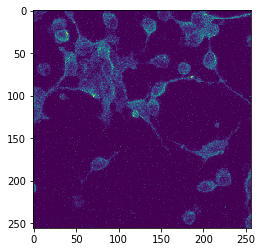

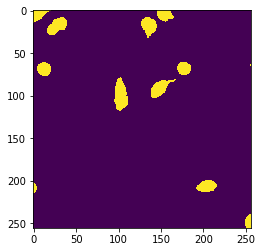

In [7]:
plt.imshow(test_im[:,:,2])
plt.show()
plt.imshow(test_mask[:,:,0])
plt.show()

### Model

In [8]:
unet_model = model.unet(input_size = unet_input_size ,output_size = unet_output_size)

In [9]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Train

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import os

model_file = os.path.join(OUTPUT_PATH,model_name)
# mean_io_u
model_checkpoint = ModelCheckpoint(model_file, monitor='val_loss',verbose=1, save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [11]:
history = unet_model.fit_generator(gen_train_fast,validation_data =gen_test_fast,validation_steps=10,steps_per_epoch=100,epochs=20,callbacks=[model_checkpoint])


Epoch 1/20
49/50 [============================>.] - ETA: 0s - loss: 0.5435 - accuracy: 0.0411 - mean_io_u: 0.3551
Epoch 00001: val_loss improved from inf to 0.39818, saving model to ../../../../data/cells/models/10_09_2020_unet_without_bg_cells.hdf5
50/50 [==============================] - 51s 1s/step - loss: 0.5455 - accuracy: 0.0412 - mean_io_u: 0.3551 - val_loss: 0.3982 - val_accuracy: 0.0358 - val_mean_io_u: 0.3507
Epoch 2/20
49/50 [============================>.] - ETA: 0s - loss: 0.5780 - accuracy: 0.0421 - mean_io_u: 0.3523
Epoch 00002: val_loss did not improve from 0.39818
50/50 [==============================] - 45s 896ms/step - loss: 0.5761 - accuracy: 0.0423 - mean_io_u: 0.3525 - val_loss: 0.4027 - val_accuracy: 0.0351 - val_mean_io_u: 0.3502
Epoch 3/20
49/50 [============================>.] - ETA: 0s - loss: 0.5434 - accuracy: 0.0446 - mean_io_u: 0.3542
Epoch 00003: val_loss did not improve from 0.39818
50/50 [==============================] - 45s 894ms/step - loss: 0.5430 

### Test

In [12]:
im,mask = next(gen_train_fast)

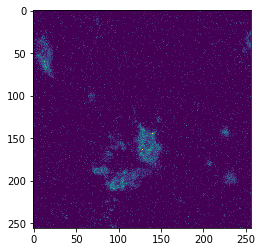

In [13]:
import matplotlib.pyplot as plt
plt.imshow(im[0][:,:,2])
# print(im[0])

In [14]:
results = unet_model.predict(im)

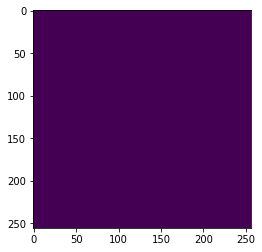

In [15]:
plt.imshow(results[3][:,:,1])

In [20]:
import json
history2_file = os.path.join(OUTPUT_PATH,d1+'history_unet_without_background_cells.json')
history_v2_dict = history.history
json.dump(str(history_v2_dict), open(history2_file, 'w'))

In [19]:
str(history_v2_dict)

"{'loss': [0.5455260922014713, 0.5761440199613571, 0.543001195192337, 0.5454626786708832, 0.5571039688587188, 0.5573421162366867, 0.542703201174736, 0.5744228410720825, 0.5571072447299957, 0.548071722984314, 0.5518608808517456, 0.5665940642356873, 0.5365148800611496, 0.5542567688226699, 0.5486320596933365, 0.5787198603153229, 0.5627917933464051, 0.5403138762712478, 0.5555467289686203, 0.5424002861976623], 'accuracy': [0.041203205, 0.042263668, 0.044563167, 0.041939035, 0.043453828, 0.04065628, 0.04282374, 0.04359131, 0.041862845, 0.04272255, 0.042359974, 0.04199056, 0.043487497, 0.043586478, 0.045017317, 0.04237193, 0.04581932, 0.041259993, 0.042870943, 0.04398407], 'mean_io_u': [0.35508657, 0.35245624, 0.35421535, 0.35262215, 0.35338822, 0.3517192, 0.3531818, 0.35326654, 0.35244054, 0.35305855, 0.352798, 0.35240555, 0.3536503, 0.35350072, 0.3544197, 0.35249054, 0.3547303, 0.3522776, 0.3530592, 0.35387722], 'val_loss': [0.3981770545244217, 0.4026798397302628, 0.40225558578968046, 0.419